# Methodology VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper

In [3]:
ship_name = "optiwise"
model = catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple']()

[11/05/24 16:36:20] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=974530;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=576218;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=357370;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=347281;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=424139;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=745141;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [31]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
df_VCT = model.prime(data=df_VCT)


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])
df_VCT['delta_deg'] = np.rad2deg(df_VCT['delta']).round(decimals=2)

[11/05/24 18:16:22] INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=264847;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=118284;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
ids = [
    23590,
    23591,
    23594,
    23596,
]

meta_datas = meta_data_all.loc[ids].copy()


                    INFO     Loading data from 'optiwise.time_series_meta_data' (CSVDataSet)... ]8;id=168446;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=482052;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [6]:

dataframes = {}
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = model.prime(df_EKF_smooth)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    dataframes[name] = df_EKF_smooth

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=359973;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=148524;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=90550;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214628;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/05/24 16:36:36] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=448085;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=691937;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=466696;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=905181;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=136841;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=363593;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

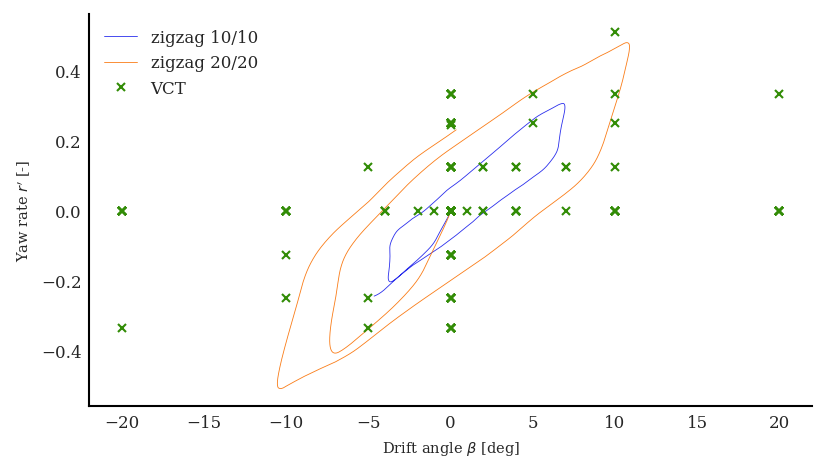

In [7]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r',ax=ax, label=name)

df_VCT.plot(x='beta_deg', y='r', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Yaw rate $r'$ [-]")

ax.legend(loc='upper left')
paper.save_fig(fig,"phase_plot.svg")

Text(0, 0.5, 'Rudder angle $\\delta$ [deg]')

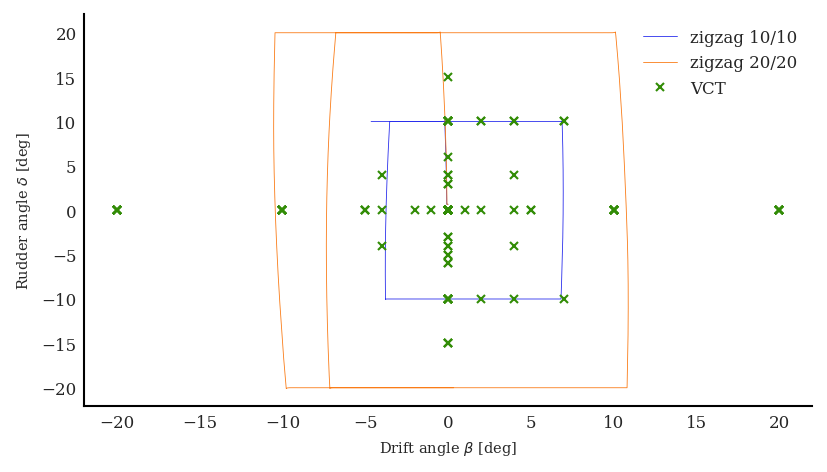

In [26]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data['delta_deg'] = np.rad2deg(data['delta'])
    data.plot(x='beta_deg',y='delta_deg',ax=ax, label=name)

df_VCT.plot(x='beta_deg', y='delta_deg', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Rudder angle $\delta$ [deg]")

Text(0, 0.5, 'Rudder angle $\\delta$ [deg]')

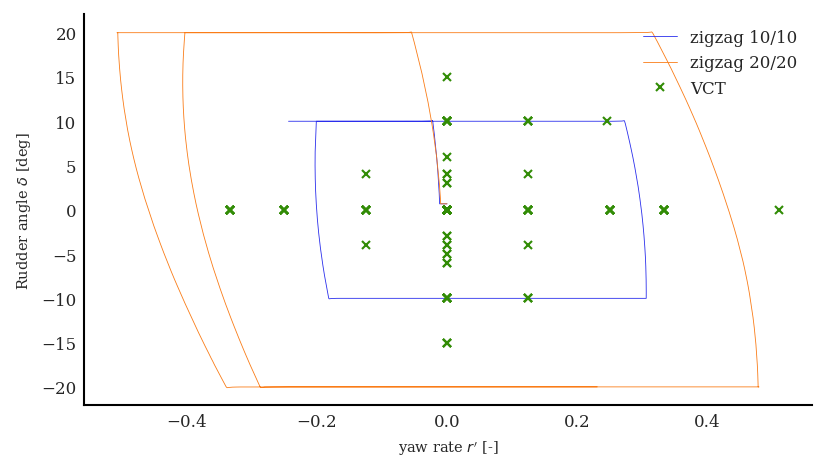

In [33]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data['delta_deg'] = np.rad2deg(data['delta'])
    data.plot(x='r',y='delta_deg',ax=ax, label=name)

df_VCT.plot(x='r', y='delta_deg', style='x', label='VCT', ax=ax)

ax.set_xlabel(r"yaw rate $r'$ [-]")
ax.set_ylabel(r"Rudder angle $\delta$ [deg]")

In [27]:
df_VCT['delta_deg'].unique()


array([  0.,  10., -10.,  -4.,   4.,   3.,  -3.,  -6.,  15.,   6., -15.,
        -5.])

Text(0.5, 1.0, '$\\delta=$-10 [deg]')

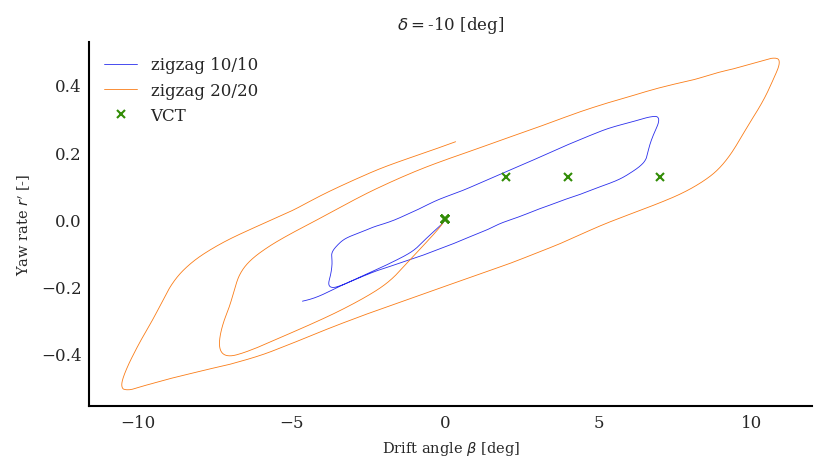

In [34]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r',ax=ax, label=name)

delta_ = -10
mask = df_VCT['delta_deg'] == delta_
df_VCT.loc[mask].plot(x='beta_deg', y='r', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Yaw rate $r'$ [-]")

ax.legend(loc='upper left')
ax.set_title(f"$\delta=${delta_} [deg]")

Text(0.5, 1.0, '$\\delta=$10 [deg]')

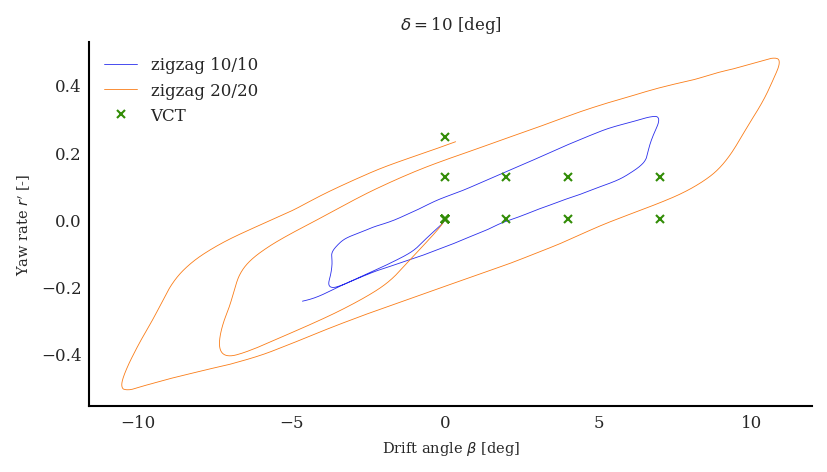

In [35]:
fig,ax=plt.subplots()

for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r',ax=ax, label=name)

delta_ = 10
mask = df_VCT['delta_deg'] == delta_
df_VCT.loc[mask].plot(x='beta_deg', y='r', style='x', label='VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
ax.set_ylabel(r"Yaw rate $r'$ [-]")

ax.legend(loc='upper left')
ax.set_title(f"$\delta=${delta_} [deg]")

In [21]:
print(paper.save_eq(Eq(X_D_,sp.solve(model.eq_VCT_X, X_D_)[0])))

<IPython.core.display.HTML object>

<IPython.core.display.Math object>

<IPython.core.display.HTML object>

X_{D} = X_{VCT} + Y_{\dot{r}} r^{2} + Y_{\dot{v}} r v


In [22]:
print(paper.save_eq(Eq(Y_D_,sp.solve(model.eq_VCT_Y, Y_D_)[0])))

<IPython.core.display.HTML object>

<IPython.core.display.Math object>

<IPython.core.display.HTML object>

Y_{D} = - X_{\dot{u}} r u + Y_{VCT}


In [23]:
print(paper.save_eq(Eq(N_D_,sp.solve(model.eq_VCT_N, N_D_)[0])))

<IPython.core.display.HTML object>

<IPython.core.display.Math object>

<IPython.core.display.HTML object>

N_{D} = N_{VCT} + X_{\dot{u}} u v - Y_{\dot{r}} r u - Y_{\dot{v}} u v


In [24]:
model.X_D_eq

Eq(X_D, X_H(u, v, r, delta) + X_P(u, v, r, rev) + X_R(u, v, r, delta, thrust) + X_RHI() + X_W(C_x0, aws, A_XV, awa, C_x5, C_x2, rho_A, C_x1, C_x3, C_x4))